# Исследовательский анализ данных о бронировании билетов на сервисе Яндекс Афиша в Python и проверка гипотез о разнице в поведении пользователей с мобильными и стационарными устройствами

- Автор: Щербань Сергей
- Дата: 14.10.2025

# Цели и задачи проекта

Цель исследования: провести исследовательский анализ данных в Python, чтобы выявить инсайты об изменении пользовательских предпочтений и популярности событий осенью 2024 года, а также проверить гипотезы о разнице в поведении пользователей с мобильными и стационарными устройствами

Задачи исследования включают:
- Выделить ключевые события, которые стали привлекать больше зрителей.
- Определить какие организаторы и площадки выбились в лидеры.
- Проверить отличаются ли своей активностью пользователи мобильных устройств от клиентов, которые бронируют билеты со стационарного компьютера.
- Сделать выводы и предложить возможные объяснения о причине изменения в пользовательском спросе.

# Описание данных

Датасет:
- `'https://code.s3.yandex.net/datasets/final_tickets_orders_df.csv'` - включает информацию обо всех заказах билетов, совершённых с двух типов устройств — мобильных и стационарных

Таблица `final_tickets_orders_df.csv` содержит:
- `order_id` — уникальный идентификатор заказа.
- `user_id` — уникальный идентификатор пользователя.
- `created_dt_msk` — дата создания заказа (московское время).
- `created_ts_msk` — дата и время создания заказа (московское время).
- `event_id` — идентификатор мероприятия из таблицы events.
- `cinema_circuit` — сеть кинотеатров. Если не применимо, то здесь будет значение 'нет'.
- `age_limit` — возрастное ограничение мероприятия.
- `currency_code` — валюта оплаты, например rub для российских рублей.
- `device_type_canonical` — тип устройства, с которого был оформлен заказ, например mobile для мобильных устройств, desktop для стационарных.
- `revenue` — выручка от заказа.
- `service_name` — название билетного оператора.
- `tickets_count` — количество купленных билетов.
- `total` — общая сумма заказа.
- `days_since_prev` - количеством дней с предыдущей покупки для каждого пользователя.

Датасет:
- `'https://code.s3.yandex.net/datasets/final_tickets_events_df.csv'` - содержит информацию о событиях, включая город и регион события, а также информацию о площадке проведения мероприятия

Таблица `final_tickets_events_df.csv` содержит:
- `event_id` — уникальный идентификатор мероприятия.
- `event_name` — название мероприятия. Аналог поля event_name_code из исходной базы данных.
- `event_type_description` — описание типа мероприятия.
- `event_type_main` — основной тип мероприятия: театральная постановка, концерт и так далее.
- `organizers` — организаторы мероприятия.
- `region_name` — название региона.
- `city_name` — название города.
- `city_id` - уникальный идентификатор города.
- `venue_id` — уникальный идентификатор площадки.
- `venue_name` — название площадки.
- `venue_address` — адрес площадки.

Датасет:
- `'https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv'` - с информацией о курсе тенге к российскому рублю за 2024 год

Таблица `final_tickets_tenge_df.csv` содержит:
- `nominal` — номинал (100 тенге).
- `data` — дата.
- `curs` — курс тенге к рублю.
- `cdx` — обозначение валюты (kzt).

# Содержимое проекта

- 1. Загрузка данных и знакомство с ними
- 2. Предобработка данных и подготовка их к исследованию
 - 2.1 Проверка данных на пропуски
 - 2.2 Проверка значений в ключевых столбцах
 - 2.3 Проверка явных и неявных дубликатов
 - 2.4 Проверка на необходимость преобразования типов данных
 - 2.5 Подготовка к исследованию, создание новых столбцов
- 3. Исследовательский анализ данных
 - 3.1 Анализ распределения заказов по сегментам и их сезонные изменения
 - 3.2 Осенняя активность пользователей
 - 3.3 Популярные события и партнёры
- 4. Статистический анализ данных
 - 4.1 Проверка гипотезы о количестве заказов
 - 4.2 Проверка гипотезы о времени между заказами
- 5. Общий вывод и рекомендации

---

# 1. Загрузка данных и знакомство с ними

<b>1.1 Загрузим данные включающие информацию обо всех заказах билетов</b>, совершённых с двух типов устройств — мобильных и стационарных из файла `/datasets/final_tickets_orders_df.csv`.

In [1]:
# Загрузка библиотек
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import mannwhitneyu

In [2]:
# Загрузка данных обо всех заказах билетов
data_orders = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_orders_df.csv')

In [3]:
# Просмотр первых строк данных data_orders
display(data_orders.head())
data_orders.info()
duplicates_orders = data_orders[data_orders.duplicated()]
print("Количество дубликатов:", data_orders.duplicated().sum())

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0


<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 290849 entries, 0 to 290848
,Data columns (total 14 columns):
, #   Column                 Non-Null Count   Dtype  
,---  ------                 --------------   -----  
, 0   order_id               290849 non-null  int64  
, 1   user_id                290849 non-null  object 
, 2   created_dt_msk         290849 non-null  object 
, 3   created_ts_msk         290849 non-null  object 
, 4   event_id               290849 non-null  int64  
, 5   cinema_circuit         290849 non-null  object 
, 6   age_limit              290849 non-null  int64  
, 7   currency_code          290849 non-null  object 
, 8   device_type_canonical  290849 non-null  object 
, 9   revenue                290849 non-null  float64
, 10  service_name           290849 non-null  object 
, 11  tickets_count          290849 non-null  int64  
, 12  total                  290849 non-null  float64
, 13  days_since_prev        268909 non-null  float64
,dtypes: float64(3), in

Датафрейм `data_orders` содержит 14 столбцов и 290849 строк, в которых представлена информация обо всех заказах билетов на сервисе Яндекс Афиша за период с 1 июня по 30 октября 2024 года. Названия столбцов имеют общий вид snake_case, а значения в столбцах соответствуют своему описанию. Явные дубликаты отсутствуют. Столбец `days_since_prev` с количеством дней с предыдущей покупки для каждого пользователя содержит пропуски, т.к. пользователь не совершал покупки.

<b>1.2 Загрузим данные содержащие информацию о событиях</b>, включая город и регион события, а также информацию о площадке проведения мероприятия из файла `/datasets/final_tickets_events_df.csv`.

In [4]:
# Загрузка данных с информацией о событиях
data_events = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_events_df.csv')

In [5]:
# Просмотр первых строк данных data_events
display(data_events.head())
data_events.info()
duplicates_events = data_events[data_events.duplicated()]
print("Количество дубликатов:", data_events.duplicated().sum())

,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,Североярская область,Озёрск,2,1600,"Кладбище искусств ""Проблема"" и партнеры","наб. Загородная, д. 785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,Светополянский округ,Глиноград,54,2196,"Лекции по искусству ""Свет"" Групп","ул. Ягодная, д. 942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,Североярская область,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6"
3,8849,682e3129-6a32-4952-9d8a-ef7f60d4c247,спектакль,театр,№4960,Каменевский регион,Глиногорск,213,1987,"Выставка ремесел ""Свет"" Лтд","пер. Набережный, д. 35"
4,8850,d6e99176-c77f-4af0-9222-07c571f6c624,спектакль,театр,№4770,Лесодальний край,Родниковец,55,4230,"Фестивальный проект ""Листья"" Групп","пер. Проезжий, д. 9"


<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 22427 entries, 0 to 22426
,Data columns (total 11 columns):
, #   Column                  Non-Null Count  Dtype 
,---  ------                  --------------  ----- 
, 0   event_id                22427 non-null  int64 
, 1   event_name              22427 non-null  object
, 2   event_type_description  22427 non-null  object
, 3   event_type_main         22427 non-null  object
, 4   organizers              22427 non-null  object
, 5   region_name             22427 non-null  object
, 6   city_name               22427 non-null  object
, 7   city_id                 22427 non-null  int64 
, 8   venue_id                22427 non-null  int64 
, 9   venue_name              22427 non-null  object
, 10  venue_address           22427 non-null  object
,dtypes: int64(3), object(8)
,memory usage: 1.9+ MB
,Количество дубликатов: 0


Датафрейм `data_events` содержит 11 столбцов и 22426 строк, в которых представлена информация о событиях, включая город и регион события, а также информацию о площадке проведения мероприятия. Названия столбцов имеют общий вид snake_case, а значения в столбцах соответствуют своему описанию. Явные дубликаты отсутствуют.

<b>1.3 Загрузим данные с информацией о курсе тенге</b> к российскому рублю за 2024 год из файла `/datasets/final_tickets_tenge_df.csv`.

In [6]:
# Загрузка данных с информацией о курсе тенге
data_tenge = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

In [7]:
# Просмотр первых строк данных data_tenge
display(data_tenge.head())
data_tenge.info()
duplicates_tenge = data_tenge[data_tenge.duplicated()]
print("Количество дубликатов:", data_tenge.duplicated().sum())

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 357 entries, 0 to 356
,Data columns (total 4 columns):
, #   Column   Non-Null Count  Dtype  
,---  ------   --------------  -----  
, 0   data     357 non-null    object 
, 1   nominal  357 non-null    int64  
, 2   curs     357 non-null    float64
, 3   cdx      357 non-null    object 
,dtypes: float64(1), int64(1), object(2)
,memory usage: 11.3+ KB
,Количество дубликатов: 0


Датафрейм `data_tenge` содержит 4 столбца и 357 строк, в которых представлена информация о курсе тенге к российскому рублю за 2024 год. Названия столбцов имеют общий вид snake_case, а значения в столбцах соответствуют своему описанию. Явные дубликаты отсутствуют.

Перед началом исследования планируется проверить данные на пропуски, нормализовать данные (проверить на выброси и отсутсвие данных), поиск неявных дубликатов, проверка на необходимость преобразования типов данных, итоговая подготовка к исследованию, создание новых столбцов.

В целом, данные выглядят структурированными и пригодными для дальнейшего анализа, но требуют внимательного подхода к работе с пропусками и возможному преобразованию данных для получения более глубоких инсайтов, выявлению интересующих закономерностей и тенденций. Предполагается объединить данные в один датафрейм, а только затем провести общую предобработку.

---

# 2. Предобработка данных и подготовка их к исследованию

<b>2.1 Проверка данных на пропуски</b>

Обединение данных с заказами и событиями:

In [8]:
# Объединяем data_orders и data_events
data = pd.merge(data_orders, data_events, on='event_id', how='left')
display(data.head())
data.info()
duplicates = data[data.duplicated()]
print("Количество дубликатов:", data.duplicated().sum())

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213.0,3972.0,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6"
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,...,40efeb04-81b7-4135-b41f-708ff00cc64c,событие,выставки,№4850,Каменевский регион,Глиногорск,213.0,2941.0,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4"
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,...,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,цирковое шоу,другое,№1540,Каменевский регион,Глиногорск,213.0,4507.0,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6"
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,...,2f638715-8844-466c-b43f-378a627c419f,выставка,другое,№5049,Североярская область,Озёрск,2.0,3574.0,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8"
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,...,10d805d3-9809-4d8a-834e-225b7d03f95d,шоу,стендап,№832,Озернинский край,Родниковецк,240.0,1896.0,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8"


<class 'pandas.core.frame.DataFrame'>
,Int64Index: 290849 entries, 0 to 290848
,Data columns (total 24 columns):
, #   Column                  Non-Null Count   Dtype  
,---  ------                  --------------   -----  
, 0   order_id                290849 non-null  int64  
, 1   user_id                 290849 non-null  object 
, 2   created_dt_msk          290849 non-null  object 
, 3   created_ts_msk          290849 non-null  object 
, 4   event_id                290849 non-null  int64  
, 5   cinema_circuit          290849 non-null  object 
, 6   age_limit               290849 non-null  int64  
, 7   currency_code           290849 non-null  object 
, 8   device_type_canonical   290849 non-null  object 
, 9   revenue                 290849 non-null  float64
, 10  service_name            290849 non-null  object 
, 11  tickets_count           290849 non-null  int64  
, 12  total                   290849 non-null  float64
, 13  days_since_prev         268909 non-null  float64
, 14  e

Получились пропуски в 238 строках, для которых не нашлось `event_id`. Используем заглушку.

In [9]:
# Заменим пропуски на unknown в столбцах, для которых event_id не найдены в объединенном df 
event_cols = ['event_name', 'event_type_description', 'event_type_main', 'organizers', 'region_name','city_name', 'venue_name', 
              'venue_address']
data[event_cols] = data[event_cols].fillna("unknown")
# В столбцах с индентификаторами 'city_id', 'venue_id' заменим пропуски на "заглушку": -1
data['city_id'] = data['city_id'].fillna(-1).astype(int)
data['venue_id'] = data['venue_id'].fillna(-1).astype(int)

Проверим результат:

In [10]:
display(data.head())
data.info()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6"
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,...,40efeb04-81b7-4135-b41f-708ff00cc64c,событие,выставки,№4850,Каменевский регион,Глиногорск,213,2941,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4"
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,...,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,цирковое шоу,другое,№1540,Каменевский регион,Глиногорск,213,4507,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6"
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,...,2f638715-8844-466c-b43f-378a627c419f,выставка,другое,№5049,Североярская область,Озёрск,2,3574,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8"
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,...,10d805d3-9809-4d8a-834e-225b7d03f95d,шоу,стендап,№832,Озернинский край,Родниковецк,240,1896,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8"


<class 'pandas.core.frame.DataFrame'>
,Int64Index: 290849 entries, 0 to 290848
,Data columns (total 24 columns):
, #   Column                  Non-Null Count   Dtype  
,---  ------                  --------------   -----  
, 0   order_id                290849 non-null  int64  
, 1   user_id                 290849 non-null  object 
, 2   created_dt_msk          290849 non-null  object 
, 3   created_ts_msk          290849 non-null  object 
, 4   event_id                290849 non-null  int64  
, 5   cinema_circuit          290849 non-null  object 
, 6   age_limit               290849 non-null  int64  
, 7   currency_code           290849 non-null  object 
, 8   device_type_canonical   290849 non-null  object 
, 9   revenue                 290849 non-null  float64
, 10  service_name            290849 non-null  object 
, 11  tickets_count           290849 non-null  int64  
, 12  total                   290849 non-null  float64
, 13  days_since_prev         268909 non-null  float64
, 14  e

Пропуски содержатся только в `days_since_prev`, что не является ошибкой.

<b>2.2 Проверка значений в ключевых столбцах</b>

<b>2.2.1 Проверка категориальных значений</b>

In [11]:
# Проверяем значения
columns_to_check = ['cinema_circuit', 'age_limit', 'currency_code', 'device_type_canonical', 'event_type_main', 'region_name']

In [12]:
for column in columns_to_check:
    if column in data.columns:
        value_counts = data[column].value_counts()
        percentages = (value_counts / len(data)) * 100
        percentages = percentages.round(2)  # Округляем до сотых
        print(f"Количество значений в столбце '{column}':")
        display(pd.DataFrame({'Count': value_counts, 'Percentage': percentages}))
        print("\n")
    else:
        print(f"Столбец '{column}' не найден в датафрейме.")
        print("\n")

Количество значений в столбце 'cinema_circuit':


,Count,Percentage
нет,289451,99.52
Другое,1261,0.43
КиноСити,122,0.04
Киномакс,7,0.00
Москино,7,0.00
ЦентрФильм,1,0.00



,
,Количество значений в столбце 'age_limit':


,Count,Percentage
16,78579,27.02
12,62557,21.51
0,61487,21.14
6,52173,17.94
18,36053,12.40



,
,Количество значений в столбце 'currency_code':


,Count,Percentage
rub,285780,98.26
kzt,5069,1.74



,
,Количество значений в столбце 'device_type_canonical':


,Count,Percentage
mobile,232679,80.0
desktop,58170,20.0



,
,Количество значений в столбце 'event_type_main':


,Count,Percentage
концерты,115276,39.63
театр,67321,23.15
другое,65867,22.65
спорт,21911,7.53
стендап,13393,4.60
выставки,4854,1.67
ёлки,1989,0.68
unknown,238,0.08



,
,Количество значений в столбце 'region_name':


,Count,Percentage
Каменевский регион,91058,31.31
Североярская область,44049,15.14
Широковская область,16457,5.66
Медовская область,13901,4.78
Озернинский край,10476,3.60
...,...,...
Лесноярский край,19,0.01
Крутоводский регион,18,0.01
Верхозёрский край,11,0.00
Сосноводолинская область,10,0.00



,


- В столбце `cinema_circuit` 289451 строк содержат заглушку `нет`, обозначающие пропуски в данных или отсутствие информации.
- В столбцах `cinema_circuit`, `service_name`, `region_name`, `city_name` необходимо привести значения к единому нижнему регистру.

In [13]:
# Приведем категориальные данные к нижнему регистру
cols_to_lower = ['cinema_circuit', 'service_name', 'region_name', 'city_name']

for col in cols_to_lower:
    data[col] = data[col].str.lower()

Категориальные данные в текущем наборе данных уже находятся в подходящем формате и не требуют дополнительной предобработки. Они готовы к дальнейшему анализу или использованию в исследовании.

<b>2.2.2 Проверка количественных значений</b>

Основные количественные значения это выручка - `revenue`, количество купленх билетов - `tickets_count` и общая сумма заказа - `total`.

In [14]:
# Проверим данные в столбцах
num_cols = ['revenue', 'tickets_count', 'total']

for col in num_cols:
    print(f"\nСтатистика для {col}:")
    display(data[col].describe())


,Статистика для revenue:


count    290849.000000
mean        625.083054
std        1227.316214
min         -90.760000
25%         116.790000
50%         355.340000
75%         809.750000
max       81174.540000
Name: revenue, dtype: float64


,Статистика для tickets_count:


count    290849.000000
mean          2.754230
std           1.170467
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          57.000000
Name: tickets_count, dtype: float64


,Статистика для total:


count    290849.000000
mean       7526.465613
std       15328.267730
min        -358.850000
25%        2156.870000
50%        4771.390000
75%        8955.950000
max      811745.400000
Name: total, dtype: float64

Значения каждого имеют выбросы. Отрицательные значения в столбцах `revenue` и `total` могут быть связаны с отменой заказа, возвратом средств или использований акций.

Первым важнейшим для анализа данных показателем является выручка с заказа. Так как данные изначально были представлены в разных валютах, поэтому разделим таблицу на рубли и тенге.

Анализируем выручку в рублях:

In [15]:
# Подготовим к анализу данные с валютой rub
rub_data = data.loc[data['currency_code'] == 'rub'].reset_index(drop=True)


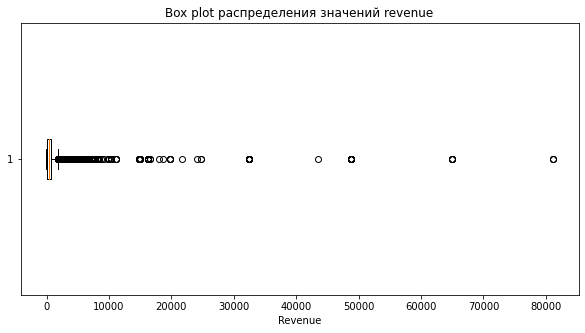

In [16]:
# Построение горизонтального box plot
plt.figure(figsize=(10, 5))  
plt.boxplot(rub_data['revenue'], vert=False)  
plt.title('Box plot распределения значений revenue')
plt.xlabel('Revenue')

plt.show()


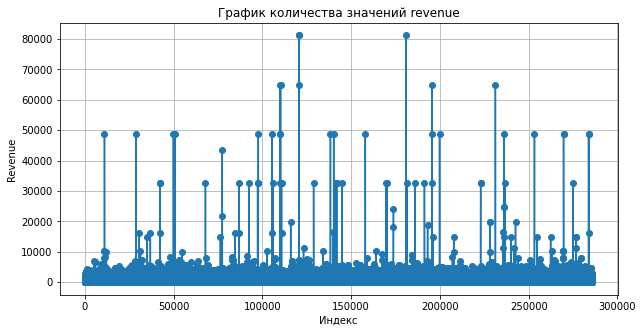

In [17]:
# Дополнительно визуализируем rub_data
plt.figure(figsize=(10, 5))
plt.plot(rub_data['revenue'], marker='o')
plt.title('График количества значений revenue')
plt.xlabel('Индекс')
plt.ylabel('Revenue')
plt.grid(True)

plt.show()


Выбросы присутствуют, отберем значения по 99-му процентилю.

In [18]:
# Вычисляем 99-й процентиль и отбираем значения ниже или равные 99-му процентилю
rub_threshold = rub_data['revenue'].quantile(0.99)
rub_filtered_data = rub_data[rub_data['revenue'] <= rub_threshold]

Проверим как выглядит диаграмма размаха теперь.

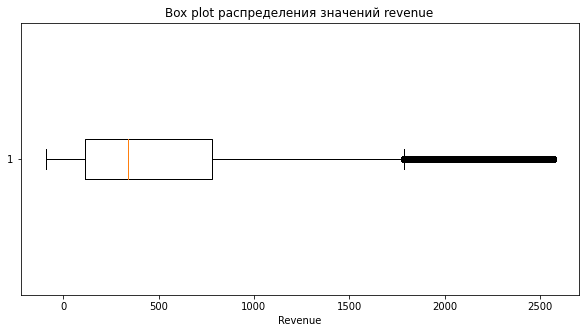

In [19]:
# Построение горизонтального box plot
plt.figure(figsize=(10, 5))  # Создаём новое окно для графика
plt.boxplot(rub_filtered_data['revenue'], vert=False)  # Построение горизонтального box plot
plt.title('Box plot распределения значений revenue')
plt.xlabel('Revenue')

plt.show()


Теперь анализируем выручку в тенге:

In [20]:
#Подготовим к анализу данные с валютой kzt
kzt_data = data.loc[data['currency_code'] == 'kzt'].reset_index(drop=True)


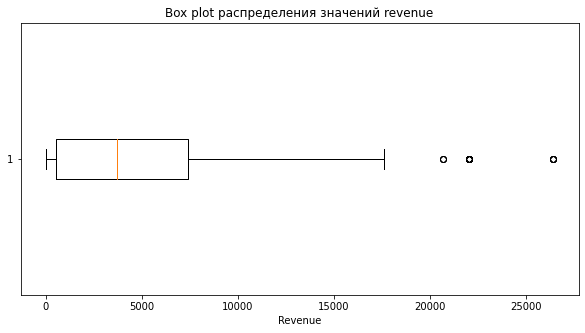

In [21]:
# Построение горизонтального box plot
plt.figure(figsize=(10, 5))  # Создаём новое окно для графика
plt.boxplot(kzt_data['revenue'], vert=False)  # Построение горизонтального box plot
plt.title('Box plot распределения значений revenue')
plt.xlabel('Revenue')

plt.show()


Медиана не смещена относительно центра ящика, это указывает на равномерность распределения данных. Выбросы с аномальными значениями присутствуют, отберем значения по 99-му процентилю.

In [22]:
# Вычисляем 99-й процентиль и отбираем значения ниже или равные 99-му процентилю
kzt_threshold = kzt_data['revenue'].quantile(0.99)
kzt_filtered_data = kzt_data[kzt_data['revenue'] <= kzt_threshold]

Объединим данные с выручкой в рублях и тенге.

In [23]:
# Объединяем kzt_filtered_data и rub_filtered_data
filtered_data = pd.concat([kzt_filtered_data, rub_filtered_data], ignore_index=True)


Теперь проверим наличие выбросов в столбце с количеством купленных билетов

In [24]:
# Оценим количество купленных билетов
filtered_data['tickets_count'].describe()


count    287962.000000
mean          2.739889
std           1.162301
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
max          57.000000
Name: tickets_count, dtype: float64

In [25]:
# Предполагаем, что data уже загружен
columns_to_check = ['tickets_count']

for column in columns_to_check:
    if column in filtered_data.columns:
        value_counts = filtered_data[column].value_counts()
        percentages = (value_counts / len(data)) * 100
        percentages = percentages.round(2)  # Округляем до сотых
        print(f"Количество значений в столбце '{column}':")
        display(pd.DataFrame({'Count': value_counts, 'Percentage': percentages}))
        print("\n")
    else:
        print(f"Столбец '{column}' не найден в датафрейме.")
        print("\n")


Количество значений в столбце 'tickets_count':


,Count,Percentage
3,91776,31.55
2,83740,28.79
4,53710,18.47
1,41810,14.38
5,12840,4.41
6,3906,1.34
7,58,0.02
9,38,0.01
10,19,0.01
8,18,0.01



,


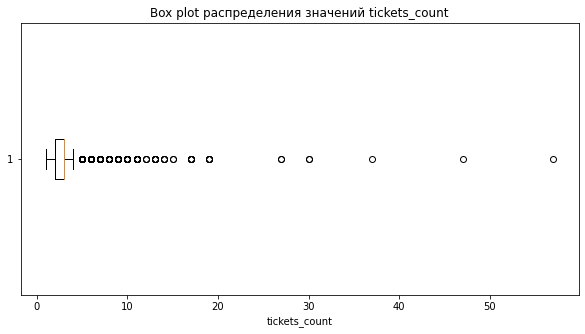

In [26]:
# Построение горизонтального box plot
plt.figure(figsize=(10, 5))  # Создаём новое окно для графика
plt.boxplot(filtered_data['tickets_count'], vert=False)  # Построение горизонтального box plot
plt.title('Box plot распределения значений tickets_count')
plt.xlabel('tickets_count')

plt.show()


Пойдем по тому же принципу - исключим по 99-му процентилю.

In [27]:
# Вычисляем 99-й процентиль и отбираем значения ниже или равные 99-му процентилю
flt_threshold = filtered_data['tickets_count'].quantile(0.99)
filtered_data = filtered_data[filtered_data['tickets_count'] <= flt_threshold]

# Предполагаем, что data уже загружен
columns_to_check = ['tickets_count']

for column in columns_to_check:
    if column in filtered_data.columns:
        value_counts = filtered_data[column].value_counts()
        percentages = (value_counts / len(data)) * 100
        percentages = percentages.round(2)  # Округляем до сотых
        print(f"Количество значений в столбце '{column}':")
        display(pd.DataFrame({'Count': value_counts, 'Percentage': percentages}))
        print("\n")
    else:
        print(f"Столбец '{column}' не найден в датафрейме.")
        print("\n")


Количество значений в столбце 'tickets_count':


,Count,Percentage
3,91776,31.55
2,83740,28.79
4,53710,18.47
1,41810,14.38
5,12840,4.41
6,3906,1.34



,


<b>2.3 Проверка явных и неявных дубликатов</b>

In [28]:
# Проверим явные дубликаты
exactra_duplicates = filtered_data[filtered_data.duplicated()]
print(f"Явных дубликатов: {len(exactra_duplicates)}")

Явных дубликатов: 0


In [29]:
# Проверим неявные дубликаты по всем столбцам кроме `order_id`
dop_duplicates = filtered_data.groupby(['user_id', 'created_dt_msk', 'created_ts_msk', 'event_id',
       'cinema_circuit', 'age_limit', 'currency_code', 'device_type_canonical',
       'revenue', 'service_name', 'tickets_count', 'total', 'days_since_prev',
       'event_name', 'event_type_description', 'event_type_main', 'organizers',
       'region_name', 'city_name', 'city_id', 'venue_id', 'venue_name',
       'venue_address']).size().reset_index(name='duplicate_count')
suspicious = dop_duplicates[dop_duplicates['duplicate_count'] > 1]
print(f"Неявных дубликатов: {len(suspicious)}")

Неявных дубликатов: 28


Так как присутствуют дубли где отличается только `order_id` - это говорит о том что могла быть ошибка при проведении чека, двойной клик или ошибка при оплате.

Уберем дубли.

In [30]:
# Чистим неявные дубли
final_data = filtered_data.drop_duplicates(subset=['user_id', 'created_dt_msk', 'created_ts_msk', 'event_id',
          'cinema_circuit', 'age_limit', 'currency_code', 'device_type_canonical',
          'revenue', 'service_name', 'tickets_count', 'total', 'days_since_prev',
          'event_name', 'event_type_description', 'event_type_main', 'organizers',
          'region_name', 'city_name', 'city_id', 'venue_id', 'venue_name',
          'venue_address'], keep='first')

In [31]:
# Считаем размер final_data после чистки дублей
row_count = final_data.shape[0]
print(f"Количество строк после удаления дублей: {row_count}")


Количество строк после удаления дублей: 287752


In [32]:
# Количество строк в начальном датафрейме
initial_row_count = data.shape[0]

# Количество строк после удаления дубликатов
final_row_count = final_data.shape[0]

# Разница в количестве строк
rows_removed = initial_row_count - final_row_count

# Процент удалённых строк
percentage_removed = (rows_removed / initial_row_count) * 100

print(f"Процент удалённых строк: {percentage_removed:.2f}%")


Процент удалённых строк: 1.06%


<b>2.4 Проверка на необходимость преобразования типов данных</b>

Актуализируем типы данных с датой и временем в конечном датафрейме `final_data` и `data_tenge`, а также проверим возможность снижения размерности количественных данных.

In [33]:
# Преобразуем столбцы с датами в тип данных datetime
final_data['created_dt_msk'] = pd.to_datetime(final_data['created_dt_msk'])
final_data['created_ts_msk'] = pd.to_datetime(final_data['created_ts_msk'])
data_tenge['data'] = pd.to_datetime(data_tenge['data'])

/tmp/ipykernel_492/2482383671.py:2: SettingWithCopyWarning: 
,A value is trying to be set on a copy of a slice from a DataFrame.
,Try using .loc[row_indexer,col_indexer] = value instead
,
,See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
,  final_data['created_dt_msk'] = pd.to_datetime(final_data['created_dt_msk'])
,/tmp/ipykernel_492/2482383671.py:3: SettingWithCopyWarning: 
,A value is trying to be set on a copy of a slice from a DataFrame.
,Try using .loc[row_indexer,col_indexer] = value instead
,
,See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
,  final_data['created_ts_msk'] = pd.to_datetime(final_data['created_ts_msk'])


In [34]:
# Оптимизируем размерность числовых столбцов 
final_data['age_limit'] = pd.to_numeric(final_data['age_limit'], downcast='integer')
final_data['tickets_count'] = pd.to_numeric(final_data['tickets_count'], downcast='integer')
final_data['city_id'] = pd.to_numeric(final_data['city_id'], downcast='integer')
final_data['venue_id'] = pd.to_numeric(final_data['venue_id'], downcast='integer')
final_data['revenue'] = pd.to_numeric(final_data['revenue'], downcast='float')
final_data['total'] = pd.to_numeric(final_data['total'], downcast='float')
final_data['days_since_prev'] = pd.to_numeric(final_data['days_since_prev'], downcast='float')


/tmp/ipykernel_492/875676592.py:2: SettingWithCopyWarning: 
,A value is trying to be set on a copy of a slice from a DataFrame.
,Try using .loc[row_indexer,col_indexer] = value instead
,
,See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
,  final_data['age_limit'] = pd.to_numeric(final_data['age_limit'], downcast='integer')
,/tmp/ipykernel_492/875676592.py:3: SettingWithCopyWarning: 
,A value is trying to be set on a copy of a slice from a DataFrame.
,Try using .loc[row_indexer,col_indexer] = value instead
,
,See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
,  final_data['tickets_count'] = pd.to_numeric(final_data['tickets_count'], downcast='integer')
,/tmp/ipykernel_492/875676592.py:4: SettingWithCopyWarning: 
,A value is trying to be set on a copy of a slice from a DataFrame.
,Try using .loc[row_indexer,col_

In [35]:
display(final_data.head())
final_data.info()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,7850214,0033403583a55ed,2024-09-17,2024-09-17 16:52:06,559919,нет,6,kzt,mobile,518.099976,...,f5ec2467-ee48-42f3-89a0-a2d90d1d6fce,событие,другое,№5088,верхоречная область,серебрянка,163,1533,"Клуб настольного тенниса ""Фазенда"" Инк","пер. Семашко, д. 8/7 стр. 7"
1,8634925,0040e12d70fae81,2024-09-02,2024-09-02 19:49:14,559476,нет,6,kzt,desktop,347.179993,...,61ec7c0e-ea0c-4a3e-a63a-09cbe1bc6177,событие,другое,№5088,верхоречная область,серебрянка,163,1533,"Клуб настольного тенниса ""Фазенда"" Инк","пер. Семашко, д. 8/7 стр. 7"
2,7625522,0054b38b2653e6e,2024-09-09,2024-09-09 18:06:04,559582,нет,6,kzt,mobile,328.769989,...,524f434e-0381-4f47-9688-7c4e41961b65,событие,другое,№5088,верхоречная область,серебрянка,163,1533,"Клуб настольного тенниса ""Фазенда"" Инк","пер. Семашко, д. 8/7 стр. 7"
3,5227657,01370a0e9c1a7d5,2024-06-04,2024-06-04 13:28:17,533803,нет,16,kzt,desktop,7397.660156,...,0686ac7b-6f3e-4177-bb73-16b54acd1223,фестиваль,концерты,№4950,шанырский регион,широковка,162,3407,"Арт-кафе ""Речка"" Лимитед","алл. Путейская, д. 548 стр. 7"
4,2229782,01370a0e9c1a7d5,2024-06-04,2024-06-04 13:17:35,533803,нет,16,kzt,mobile,3698.830078,...,0686ac7b-6f3e-4177-bb73-16b54acd1223,фестиваль,концерты,№4950,шанырский регион,широковка,162,3407,"Арт-кафе ""Речка"" Лимитед","алл. Путейская, д. 548 стр. 7"


<class 'pandas.core.frame.DataFrame'>
,Int64Index: 287752 entries, 0 to 287961
,Data columns (total 24 columns):
, #   Column                  Non-Null Count   Dtype         
,---  ------                  --------------   -----         
, 0   order_id                287752 non-null  int64         
, 1   user_id                 287752 non-null  object        
, 2   created_dt_msk          287752 non-null  datetime64[ns]
, 3   created_ts_msk          287752 non-null  datetime64[ns]
, 4   event_id                287752 non-null  int64         
, 5   cinema_circuit          287752 non-null  object        
, 6   age_limit               287752 non-null  int8          
, 7   currency_code           287752 non-null  object        
, 8   device_type_canonical   287752 non-null  object        
, 9   revenue                 287752 non-null  float32       
, 10  service_name            287752 non-null  object        
, 11  tickets_count           287752 non-null  int8          
, 12  total        

<b>Память оптимизирована на 18%.</b>

<b>2.5 Подготовка к исследованию, создание новых столбцов</b>

- `revenue_rub` — приведем выручку с заказа к единой валюте — российскому рублю. Для этого используем датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю `final_tickets_tenge_df.csv` за 2024 год. Значения в рублях представлены для 100 тенге.
- `one_ticket_revenue_rub` — рассчитаем выручку с продажи одного билета на мероприятие.
- `month` — выделим месяц оформления заказа в отдельный столбец.
- `season` — создадим столбец с информацией о сезонности, включая такие категории, как: `лето`, `осень`, `зима`, `весна`.

In [36]:
# Приведем выручку к единой валюте - rub
# Объединим df по дате 
final_data = pd.merge(final_data, data_tenge, left_on='created_dt_msk', right_on='data', how='left')

# Заполнение пропусков для рублёвых заказов
final_data['curs'] = final_data['curs'].fillna(1)
final_data['nominal'] = final_data['nominal'].fillna(100)

In [37]:
# Создаем столбец revenue_rub
def convert_to_rub(row):
    if row['currency_code'] == 'kzt':
        return (row['revenue'] * row['curs']) / row['nominal']
    else:
        return row['revenue']

final_data['revenue_rub'] = final_data.apply(convert_to_rub, axis=1)

In [38]:
# Проверяем случайные заказы в тенге
sample_kzt = final_data[final_data['currency_code'] == 'kzt'].sample(3)
display(sample_kzt[['revenue', 'curs', 'revenue_rub']])

# В рублях
sample_rub = final_data[final_data['currency_code'] == 'rub'].sample(3)
display(sample_rub[['revenue', 'curs', 'revenue_rub']])

,revenue,curs,revenue_rub
1571,7103.290039,19.1903,1363.142668
2982,74.629997,18.5504,13.844163
3025,4735.520020,18.6403,882.715138


,revenue,curs,revenue_rub
57342,1013.510010,20.0429,1013.510010
142009,31.629999,19.8697,31.629999
68006,198.029999,18.4518,198.029999


In [39]:
# Убираем лишнее
final_data = final_data.drop(columns=['data', 'nominal', 'curs', 'cdx'])

In [40]:
# Создаем новый столбец 'one_ticket_revenue_rub' с выручкой с продажи одного билета на мероприятие
final_data['one_ticket_revenue_rub'] = final_data['revenue_rub'] / final_data['tickets_count']

# Проверяем результат
display(final_data[['revenue_rub', 'tickets_count', 'one_ticket_revenue_rub']].head())

,revenue_rub,tickets_count,one_ticket_revenue_rub
0,98.503758,4,24.625939
1,65.731588,3,21.910529
2,61.148259,4,15.287065
3,1478.296622,4,369.574156
4,739.148311,2,369.574156


In [41]:
# Создадим новый столбец с месяцем заказа
final_data['month'] = final_data['created_dt_msk'].dt.month

# Создадим новый столбец с сезоном заказа (лето, осень)
# Создаем словарь сезонов
season_dt = {6: 'лето',7: 'лето', 8: 'лето',9: 'осень',10: 'осень'}

# Создаем столбец с сезоном на основе месяца
final_data['season'] = final_data['month'].map(season_dt).astype('category')

display(final_data.head())
final_data.info()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,region_name,city_name,city_id,venue_id,venue_name,venue_address,revenue_rub,one_ticket_revenue_rub,month,season
0,7850214,0033403583a55ed,2024-09-17,2024-09-17 16:52:06,559919,нет,6,kzt,mobile,518.099976,...,верхоречная область,серебрянка,163,1533,"Клуб настольного тенниса ""Фазенда"" Инк","пер. Семашко, д. 8/7 стр. 7",98.503758,24.625939,9,осень
1,8634925,0040e12d70fae81,2024-09-02,2024-09-02 19:49:14,559476,нет,6,kzt,desktop,347.179993,...,верхоречная область,серебрянка,163,1533,"Клуб настольного тенниса ""Фазенда"" Инк","пер. Семашко, д. 8/7 стр. 7",65.731588,21.910529,9,осень
2,7625522,0054b38b2653e6e,2024-09-09,2024-09-09 18:06:04,559582,нет,6,kzt,mobile,328.769989,...,верхоречная область,серебрянка,163,1533,"Клуб настольного тенниса ""Фазенда"" Инк","пер. Семашко, д. 8/7 стр. 7",61.148259,15.287065,9,осень
3,5227657,01370a0e9c1a7d5,2024-06-04,2024-06-04 13:28:17,533803,нет,16,kzt,desktop,7397.660156,...,шанырский регион,широковка,162,3407,"Арт-кафе ""Речка"" Лимитед","алл. Путейская, д. 548 стр. 7",1478.296622,369.574156,6,лето
4,2229782,01370a0e9c1a7d5,2024-06-04,2024-06-04 13:17:35,533803,нет,16,kzt,mobile,3698.830078,...,шанырский регион,широковка,162,3407,"Арт-кафе ""Речка"" Лимитед","алл. Путейская, д. 548 стр. 7",739.148311,369.574156,6,лето


<class 'pandas.core.frame.DataFrame'>
,Int64Index: 287752 entries, 0 to 287751
,Data columns (total 28 columns):
, #   Column                  Non-Null Count   Dtype         
,---  ------                  --------------   -----         
, 0   order_id                287752 non-null  int64         
, 1   user_id                 287752 non-null  object        
, 2   created_dt_msk          287752 non-null  datetime64[ns]
, 3   created_ts_msk          287752 non-null  datetime64[ns]
, 4   event_id                287752 non-null  int64         
, 5   cinema_circuit          287752 non-null  object        
, 6   age_limit               287752 non-null  int8          
, 7   currency_code           287752 non-null  object        
, 8   device_type_canonical   287752 non-null  object        
, 9   revenue                 287752 non-null  float32       
, 10  service_name            287752 non-null  object        
, 11  tickets_count           287752 non-null  int8          
, 12  total        

<b>Выводы после предобработки данных и подготовки их к исследованию</b>

- Удалено 1,06% данных (выбросы). Итоговый объем - 287752 строк.
- Объеденены датафреймы `data_orders`, `data_events` в один - `final_data`
- Пропуски: `days_since_prev`, образованы по причине отсутствия покупок у пользователей - оставлены без изменений, чтобы избежать искажения данныe; в строковых столбцах `event_name`, `event_type_description`, `event_type_main`, `organizers`, `region_name`, `city_name`, `venue_name`, `venue_address`, для которых `event_id` не найдены в объединенном датафрейме - заменены на `unknown`, в столбцах с индентификаторами `city_id`, `venue_id` - заменены на "заглушку": `-1`.
- Столбцы с датами `created_dt_msk`, `created_ts_msk` преобразованы в тип datetime.
- Оптимизирована размерность в столбцах `age_limit`, `tickets_count`, `revenue`, `total`, `days_since_prev`, `city_id`, `venue_id`.
- Категориальные данные в столбцах `cinema_circuit`, `service_name`, `region_name`, `city_name` приведены к нижнему регистру
- В количественных столбцах `revenue` и `total` c выручкой и общей суммой заказа выявлены отрицательные значения, которые могли быть образованы в результате возвратов битетов
- По столбцу `revenue` с выручкой отфильтрованы данные до 99-го перцентиля, исключив выбросы и сохранив информативность
- Дубликаты: явных нет, неявные - 28 (удалены)
- Созданы новые столбцы: `revenue_rub` — выручка с заказа к единой валюте (российский рубль), `one_ticket_revenue_rub` — выручка с продажи одного билета на мероприятие, `month` — месяц оформления заказа, `season` — сезон

---

# 3. Исследовательский анализ данных

<b>3.1 Анализ распределения заказов по сегментам и их сезонные изменения</b>

<b>3.1.1 Количество заказов по месяцам</b>

Для каждого месяца найдем количество заказов и визуализируем результаты. Проверим, фиксируется ли увеличение заказов от июня к ноябрю 2024 года.

In [42]:
monthly_orders = final_data.groupby('month')['order_id'].count()
display(monthly_orders.to_frame('Количество заказов').rename_axis('Месяц'))

,Количество заказов
Месяц,
6,34326
7,40381
8,44538
9,69293
10,99214


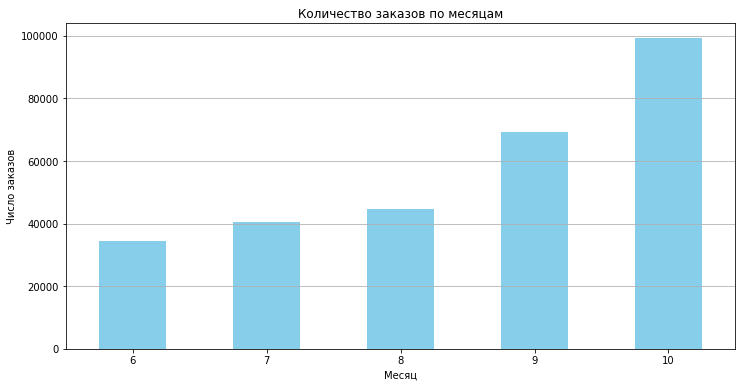

In [43]:
# Строим столбчатую диаграмму количества заказов по месяцам
plt.figure(figsize=(12, 6))
monthly_orders.plot(kind='bar', color='skyblue')
plt.title('Количество заказов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Число заказов')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

- В летние месяцы (июнь-август) фиксируется небольшое увеличение количества заказов, с наступлением осени и окончанием летних отпусков наблюдается тренд на значительное рост метрики, связанный с увеличением пользовательской активности.

<b>3.1.2 Распределение заказов билетов по сезонам </b>

Для осеннего и летнего периодов сравним распределение заказов билетов по разным категориям: тип мероприятия, тип устройства, категория мероприятия по возрастному рейтингу. Результаты визуализируем подходящим графиком, который поможет сопоставить значения для летнего и осеннего сезонов. (поскольку абсолютное количество заказов в разные сезоны может меняться, при сопоставлении результатов для каждого сегмента используем доли)

In [44]:
# Создаем отдельные таблицы для лета и осени
summer = final_data[final_data['season'] == 'лето']
autumn = final_data[final_data['season'] == 'осень']

In [45]:
# Считаем доли для каждого сезона по типу мероприятий
event_summer = summer['event_type_main'].value_counts(normalize=True).mul(100).round(1)
event_autumn = autumn['event_type_main'].value_counts(normalize=True).mul(100).round(1)

# Объединяем в одну таблицу
events_comparison = pd.DataFrame({'Лето': event_summer, 'Осень': event_autumn})
display(events_comparison)

,Лето,Осень
unknown,0.2,0.0
выставки,2.0,1.4
другое,27.1,19.7
концерты,42.6,37.2
спорт,2.5,11.2
стендап,5.3,4.1
театр,20.1,25.4
ёлки,0.2,1.0


<Figure size 864x432 with 0 Axes>

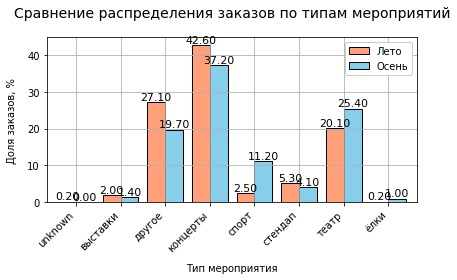

In [46]:
# Строим столбчатую диаграмму распределения заказов по типам мероприятий
plt.figure(figsize=(12, 6))
ax = events_comparison.plot(kind='bar', width=0.8, color=['#FFA07A', '#87CEEB'], edgecolor='black')

plt.title('Сравнение распределения заказов по типам мероприятий', pad=20, fontsize=14)
plt.xlabel('Тип мероприятия', labelpad=10)
plt.ylabel('Доля заказов, %', labelpad=10)
plt.xticks(rotation=45, ha='right')
plt.grid()
plt.legend(framealpha=1)
plt.tight_layout()

# Добавляем подписи значений
for container in ax.containers:
    for i, rect in enumerate(container.patches):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', fontsize=11)

plt.show()


- Летом доминируют концерты (42.6%) + другое (27.1%)
- Осенью структура более сбалансирована: концерты (37.2%) + театр (25.4%) + спорт (11.2%)

In [47]:
# Считаем доли для каждого сезона по типу устройства
device_summer = summer['device_type_canonical'].value_counts(normalize=True).mul(100).round(1)
device_autumn = autumn['device_type_canonical'].value_counts(normalize=True).mul(100).round(1)

types_comparison = pd.DataFrame({'Лето': device_summer, 'Осень': device_autumn})
display(types_comparison)

,Лето,Осень
mobile,80.7,79.7
desktop,19.3,20.3


<Figure size 864x432 with 0 Axes>

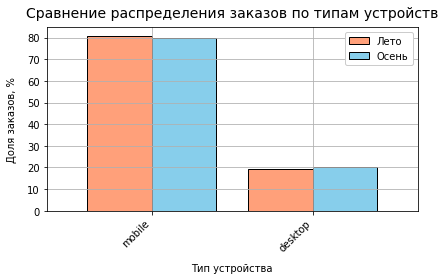

In [48]:
# Строим столбчатую диаграмму распределения заказов по типам устройств
plt.figure(figsize=(12, 6))
ax = types_comparison.plot(kind='bar', width=0.8, color=['#FFA07A', '#87CEEB'], edgecolor='black')

plt.title('Сравнение распределения заказов по типам устройств', pad=10, fontsize=14)
plt.xlabel('Тип устройства', labelpad=10)
plt.ylabel('Доля заказов, %', labelpad=10)
plt.xticks(rotation=45, ha='right')
plt.grid()

plt.legend(framealpha=1)
plt.tight_layout()
plt.show()

- Сезон не влияет на выбор устройства — мобильные доминируют круглый год.

In [49]:
# Считаем доли для каждого сезона по возрасту
age_summer = summer['age_limit'].value_counts(normalize=True).mul(100).round(1)
age_autumn = autumn['age_limit'].value_counts(normalize=True).mul(100).round(1)

ages_comparison = pd.DataFrame({'Лето': age_summer, 'Осень': age_autumn})
display(ages_comparison)

,Лето,Осень
0,17.9,23.6
6,18.2,17.6
12,20.6,22.1
16,28.3,26.2
18,15.0,10.4


<Figure size 864x432 with 0 Axes>

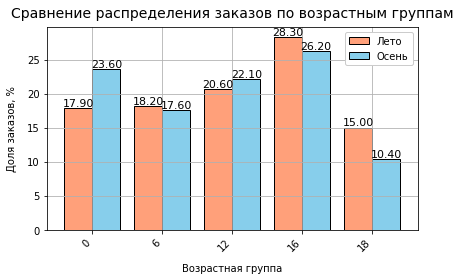

In [50]:
# Строим столбчатую диаграмму распределения заказов по возрастным группам
plt.figure(figsize=(12, 6))
ax = ages_comparison.plot(kind='bar', width=0.8, color=['#FFA07A', '#87CEEB'], edgecolor='black')

plt.title('Сравнение распределения заказов по возрастным группам', pad=10, fontsize=14)
plt.xlabel('Возрастная группа', labelpad=10)
plt.ylabel('Доля заказов, %', labelpad=10)
plt.xticks(rotation=45, ha='right')
plt.grid()
plt.legend(framealpha=1)
plt.tight_layout()

# Добавляем подписи значений
for container in ax.containers:
    for i, rect in enumerate(container.patches):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', fontsize=11)

plt.show()


- Семейный сегмент (0+ и 6+) увеличивает долю осенью (в сумме с 36.1% до 41.2%)
- Молодежная аудитория (16+ и 18+) сокращается с 43.3% до 36.6%
- Подростки (12+) остаются стабильной группой (~20-22%)

<b>3.1.3 Изменение выручки с продажи одного билета в зависимости от типа мероприятия и сезона.</b>

Изучим изменение выручки с продажи одного билета в зависимости от типа мероприятия летом и осенью. Видна ли динамика средней стоимости билета в разрезе разных категорий мероприятий. Для каждого типа мероприятия рассчитаем среднее значение выручки с одного билета, затем найдем относительное изменение осенних значений по сравнению с летними. Результат сопроводим подходящей визуализацией.

In [51]:
# Расчитаем среднюю выручку по категориям и сезонам
mean_revenue = final_data.groupby(['event_type_main', 'season'])['one_ticket_revenue_rub'].mean().unstack()
display(mean_revenue)

season,лето,осень
event_type_main,,
unknown,3.611663,15.055038
выставки,86.416197,90.603609
другое,77.391815,76.059694
концерты,304.731672,268.106925
спорт,50.744650,49.986591
стендап,218.518108,231.124973
театр,214.166973,175.984021
ёлки,271.436177,229.564211


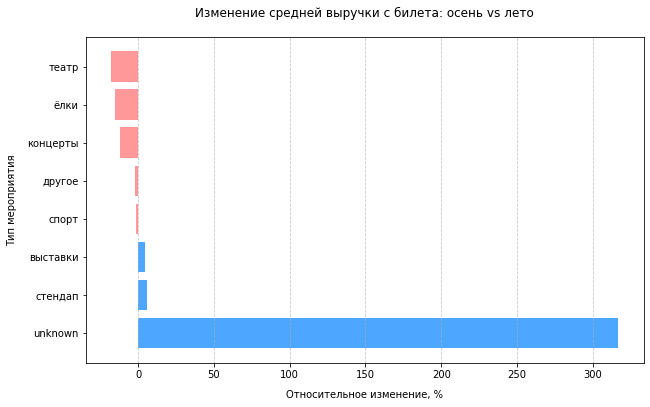

In [52]:
# Расчитаем относительное изменение
revenue_change = (mean_revenue['осень'] / mean_revenue['лето'] - 1) * 100
revenue_change = revenue_change.sort_values(ascending=False).to_frame('Изменение, %')

# Строим визуализацию
plt.figure(figsize=(10, 6))
bars = plt.barh(revenue_change.index, revenue_change['Изменение, %'], 
                color=np.where(revenue_change['Изменение, %'] > 0, '#4da6ff', '#ff9999'))

plt.title('Изменение средней выручки с билета: осень vs лето', pad=20)
plt.xlabel('Относительное изменение, %', labelpad=10)
plt.ylabel('Тип мероприятия', labelpad=10)
plt.grid(axis='x', linestyle='--', alpha=0.7)

- Театр демонстрируют резкое падение выручки: Лето: 214 руб., Осень: 175 руб. (-18.2%) Возможные причины: Осенью культурные события могут быть менее разнообразными.
- Kонцерты и ёлки также дешевеют осенью: Концерты: 304 руб. → 268 руб. (-12%). Ёлки: 271 руб. → 229 руб. (-15%) Причина: осенью преобладают локальные постановки, а не премьеры.


Помимо падения выручки в некоторых категориях, важно также отметить рост в других областях культурного сектора, таких как выставки и стендап-концерты. Эти категории демонстрируют иные тенденции, для увеличения доходов можно адаптировать стратегию привлечения своей аудитории для каждого направления:
- Выставки осенью привлекают больше посетителей из школьных и университетских экскурсий.
- Стендап-концерты могут быть более популярны осенью из-за желания людей поднять настроение в менее светлое время года.

<b>3.2 Осенняя активность пользователей</b>

Изучим активность пользователей осенью 2024 года. В нашем распоряжении данные за два осенних месяца. Используем только эти данные и сделаем следующее:
- Проанализируем динамику изменений по дням для:
 - общего числа заказов;
 - количества активных пользователей DAU;
 - среднего числа заказов на одного пользователя;
 - средней стоимости одного билета.
- Изучим недельную цикличность
- Напишем промежуточный вывод

In [53]:
# Отберем осенние месяцы
df_fall = final_data[final_data['season'] == 'осень'].copy()

In [54]:
df_fall['date'] = pd.to_datetime(df_fall['created_dt_msk'])   

In [55]:
daily_stats = df_fall.groupby('date').agg(
              total_orders=('order_id', 'count'), # общее число заказов
              unique_users=('user_id', 'nunique')).reset_index() # общее количество пользователей
display(daily_stats)

,date,total_orders,unique_users
0,2024-09-01,1327,564
1,2024-09-02,1380,574
2,2024-09-03,5111,778
3,2024-09-04,1772,684
4,2024-09-05,1940,739
...,...,...,...
56,2024-10-27,2849,1034
57,2024-10-28,2836,985
58,2024-10-29,2834,998
59,2024-10-30,2928,1040


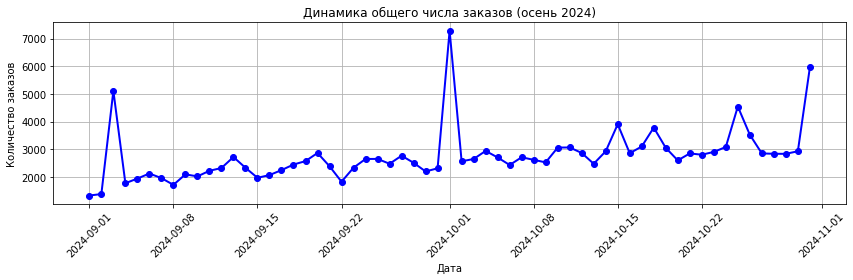

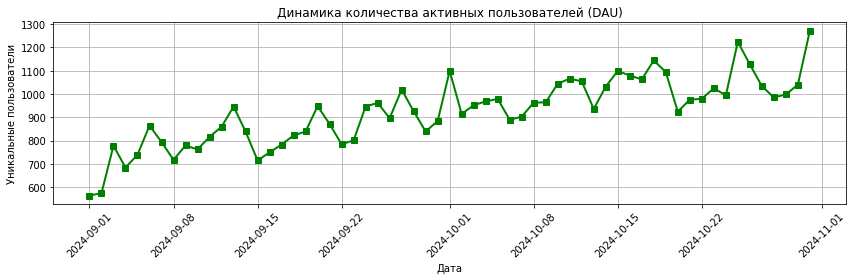

In [56]:
# Строим линейный график динамики общего числа заказов по дням
plt.figure(figsize=(12, 4))
plt.plot(daily_stats['date'], daily_stats['total_orders'], color='blue', marker='o', linestyle='-', linewidth=2)
plt.title('Динамика общего числа заказов (осень 2024)')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Строим линейный график динамики количества активных пользователей по дням
plt.figure(figsize=(12, 4))
plt.plot(daily_stats['date'], daily_stats['unique_users'], color='green', marker='s', linestyle='-', linewidth=2)
plt.title('Динамика количества активных пользователей (DAU)')
plt.xlabel('Дата')
plt.ylabel('Уникальные пользователи')
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Заказы:
- Среднедневной уровень заказов: 2500–3000.
- Пики: 3 сентября (5111 заказов) - вероятно, массовые покупки (корпоративные заказы или крупное мероприятие), 30 сентября (7287 - максимум, в 2–3 раза выше среднего) - возможно, начало акций, 31 октября (5957) - (хэллоуинский всплеск), 25 октября – 4543 заказов (локальный пик).
- Спады: 4 сентября – 1772 заказов (резкий спад после аномалии 3 сентября), 22 сентября – 1826 заказ (возможно, слабая активность в выходные).

Пользователи:
- Среднедневной уровень пользователей: ~900–1000.
- Пики: 31 октября – 1272 DAU (максимум, хэллоуинские активности), 25 октября – 1224 DAU (второй пик, возможно, концерты или фестивали), 30 сентября – 1099 DAU (аномально высокий показатель для сентября).
- Спады: 1–2 сентября – ~570 DAU (низкая активность в начале месяца, праздник 1 сентября), 22 сентября – 784 DAU (спад в выходные).

Общий тренд на рост метрик.

In [57]:
# Рассчитываем заказы на пользователя
daily_stats['orders_per_user'] = daily_stats['total_orders'] / daily_stats['unique_users']
display(daily_stats['orders_per_user'])

0     2.352837
1     2.404181
2     6.569409
3     2.590643
4     2.625169
        ...   
56    2.755319
57    2.879188
58    2.839679
59    2.815385
60    4.683176
Name: orders_per_user, Length: 61, dtype: float64

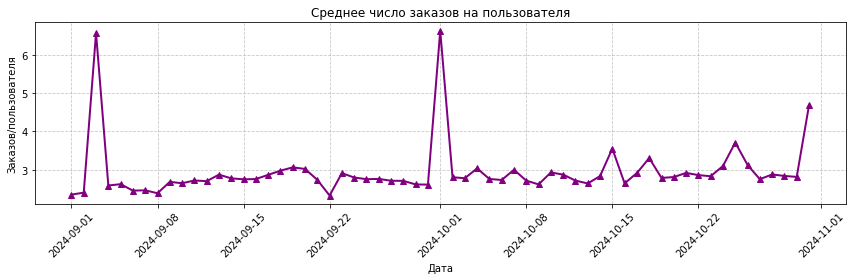

In [58]:
# Строим линейный график динамики среднего количества заказов на пользователя по дням
plt.figure(figsize=(12, 4))
plt.plot(daily_stats['date'], daily_stats['orders_per_user'], color='purple', marker='^', linestyle='-', linewidth=2)
plt.title('Среднее число заказов на пользователя')
plt.xlabel('Дата')
plt.ylabel('Заказов/пользователя')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- Типичные значения колеблются между 2.3 и 3.1, что указывает на стандартное поведение пользователей (1 пользователь делает 2-3 заказа).

Пики:
- Аномально высокие значения: 3 сентября (6.57) и 30 сентября (6.62) - экстремальные всплески, возможно, это групповые покупки, корпоративные заказы или технические сбои. Особенно показательно для 30 сентября - рекордное значение при 884 пользователях.
- 31 октября (4.69) - повышенный спрос, связанный с хэллоуинскими мероприятиями.
- 25 октября (3.74), 19 октября (3.04), 12 октября (3.55) - периоды повышенной активности, возможно связанные с популярными событиями.

Спады:
- 22 сентября (2.34) - самый низкий показатель, возможно слабая активность в выходной день.

In [59]:
# Группируем по дате и считаем сумму выручки за день
daily_revenue = df_fall.groupby('date')['revenue_rub'].sum().reset_index()
# Расчитаем среднюю стоимость билета в день
daily_stats['avg_ticket_price'] = daily_revenue['revenue_rub'] / daily_stats['total_orders']
daily_stats['avg_ticket_price']

0     547.253888
1     509.810410
2     225.240536
3     482.901238
4     508.570843
         ...    
56    512.782412
57    476.781812
58    474.811259
59    498.596608
60    388.482676
Name: avg_ticket_price, Length: 61, dtype: float64

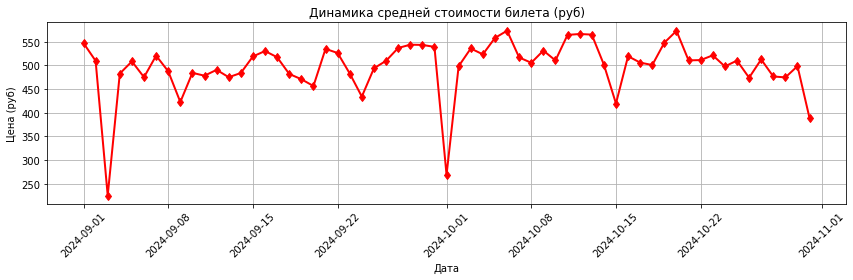

In [60]:
# Строим линейный график динамики средней стоимости билета по дням
plt.figure(figsize=(12, 4))
plt.plot(daily_stats['date'], daily_stats['avg_ticket_price'], color='red', marker='d', linestyle='-', linewidth=2)
plt.title('Динамика средней стоимости билета (руб)')
plt.xlabel('Дата')
plt.ylabel('Цена (руб)')
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- Типичный разброс: 450–650 руб.
- Выше среднего: 500–600 руб. (большинство дней)
- Ниже среднего: <500 руб. (аномально дешевые дни)

Самые низкие цены:
- 30 сентября (277 руб.) – рекордно низкая стоимость (возможно, массовые скидки или техническая ошибка).
- 3 сентября (322 руб.) – второй минимум (совпадает с пиком заказов – 5111).
- 31 октября (433 руб.) – несмотря на хэллоуин, цена ниже среднего.

Самые высокие цены:
- 1 сентября (582 руб.) – максимальная стоимость.
- 5 сентября (895 руб.) – резкий рост после дешевого 3 сентября.
- 19 октября (616 руб.) – локальный пик (совпадает с пиком среднего количества закзов на пользователя (3.04))

<b>Анализ недельной цикличности</b>

Изучим недельную цикличность. Выделим день недели и сравним пользовательскую активность в будни и выходные.

In [61]:
# Добавляем день недели (1=Пн, 7=Вс)
df_fall['day_of_week'] = df_fall['created_dt_msk'].dt.dayofweek  # 1-7
df_fall['day_name'] = df_fall['created_dt_msk'].dt.day_name()  
# Метка выходных
df_fall['is_weekend'] = df_fall['day_of_week'].isin([5, 6])  # 5=Сб, 6=Вс

In [62]:
# Группировка и агрегация
weekday_stats = df_fall.groupby(['day_name', 'is_weekend']).agg(
                total_orders=('order_id', 'count'),
                unique_users=('user_id', 'nunique'),
                total_revenue=('revenue_rub', 'sum')).reset_index()

# Расчёт производных метрик
weekday_stats['avg_orders_per_user'] = weekday_stats['total_orders'] / weekday_stats['unique_users']
weekday_stats['avg_revenue_per_user'] = weekday_stats['total_revenue'] / weekday_stats['unique_users']

# Сортировка по дням недели
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_stats['day_name'] = pd.Categorical(weekday_stats['day_name'], categories=weekday_order, ordered=True)
weekday_stats = weekday_stats.sort_values('day_name')

# Округления
weekday_stats['total_revenue'] = weekday_stats['total_revenue'].round()
weekday_stats['avg_orders_per_user'] = weekday_stats['avg_orders_per_user'].round(2)
weekday_stats['avg_revenue_per_user'] = weekday_stats['avg_revenue_per_user'].round(2)

weekday_stats

,day_name,is_weekend,total_orders,unique_users,total_revenue,avg_orders_per_user,avg_revenue_per_user
1,Monday,False,21504,4446,10734568.0,4.84,2414.43
5,Tuesday,False,31468,4793,12141908.0,6.57,2533.26
6,Wednesday,False,22868,4811,11485674.0,4.75,2387.38
4,Thursday,False,27153,4969,12997292.0,5.46,2615.68
0,Friday,False,24804,4869,12577518.0,5.09,2583.18
2,Saturday,True,21327,4569,11264760.0,4.67,2465.48
3,Sunday,True,19383,4392,10480734.0,4.41,2386.32


Рабочие дни (Пн–Пт):
- Выше средние показатели по заказам, выручке и пользователям.
- Пиковые дни:
 - Вторник – максимальные заказы (31 468).
 - Четверг – наибольшее число уникальных пользователей (4 969) и выручка (12.9 млн руб). Возможно, связаны с анонсами мероприятий, корпоративными заказами или акциями.

Выходные (Сб–Вс):
- Снижение активности на 17–25% по сравнению с рабочими днями.
- Воскресенье – минимум по всем метрикам (19 383 заказов, 4 392 пользователей). Возможно, меньше деловых/групповых покупок, пользователи чаще отдыхают.

<b>3.3 Популярные события и партнёры</b>

<b>3.3.1 Анализ мероприятий по регионам</b>

Для каждого региона посчитаем уникальное количество мероприятий и общее число заказов. В каких регионах предлагается наибольшее разнообразие мероприятий.

In [63]:
# Отберем осенние месяцы
df_autumn = final_data[final_data['season'] == 'осень'].copy()

# Группируем по регионам
region_stats = df_autumn.groupby('region_name').agg(
               unique_events=('event_id', 'nunique'),  # Уникальные мероприятия
               total_orders=('order_id', 'count'),     # Общее число заказов
               unique_users=('user_id', 'nunique')).reset_index() # Уникальные пользователи

# Сортируем по количеству уникальных мероприятий (по убыванию)
region_stats = region_stats.sort_values('unique_events', ascending=False)
region_stats

,region_name,unique_events,total_orders,unique_users
24,каменевский регион,3910,46669,6994
60,североярская область,2610,20655,4012
76,широковская область,803,8715,2063
57,светополянский округ,764,4778,1192
52,речиновская область,529,3564,1030
...,...,...,...,...
18,залесский край,4,56,24
0,unknown,4,22,15
56,светолесский край,2,18,10
6,верхозёрский край,2,11,5


In [64]:
# ТОП-5 регионов по разнообразию событий
top_5 = region_stats.sort_values('unique_events', ascending=False).head(5)

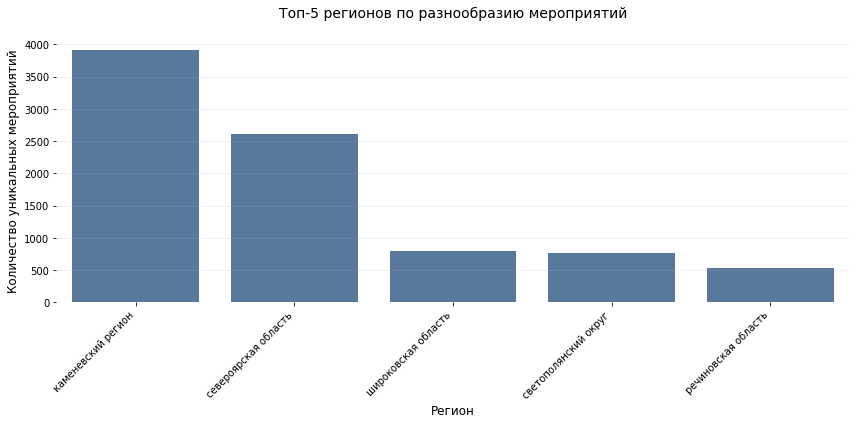

In [65]:
plt.figure(figsize=(12, 6))

# Создаем столбчатую диаграмму
ax = sns.barplot(data=top_5,
                x='region_name',
                y='unique_events',
                color='#4e79a7',  
                saturation=0.75)

plt.title('Топ-5 регионов по разнообразию мероприятий', pad=20, fontsize=14)
plt.xlabel('Регион', fontsize=12)
plt.ylabel('Количество уникальных мероприятий', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Убираем лишние границы
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()

In [66]:
# Расчитаем для каждого региона долю мероприятий от их общего числа и долю заказов в регионе от общего числа заказов.
# Общее количество мероприятий и заказов
total_events = df_autumn['event_id'].nunique()
total_orders = df_autumn['order_id'].count()

# Группируем по регионам
region_stats = df_autumn.groupby('region_name').agg(
               region_events=('event_id', 'nunique'),  # Уникальные мероприятия в регионе
               region_orders=('order_id', 'count')).reset_index()     # Заказы в регионе

# Расчитываем доли
region_stats['events_share'] = (region_stats['region_events'] / total_events * 100).round(2)
region_stats['orders_share'] = (region_stats['region_orders'] / total_orders * 100).round(2)

In [67]:
top_regions_events = region_stats.sort_values('events_share', ascending=False).head(5)
display(top_regions_events[['region_name', 'events_share', 'orders_share']])

,region_name,events_share,orders_share
24,каменевский регион,24.63,27.70
60,североярская область,16.44,12.26
76,широковская область,5.06,5.17
57,светополянский округ,4.81,2.84
52,речиновская область,3.33,2.12


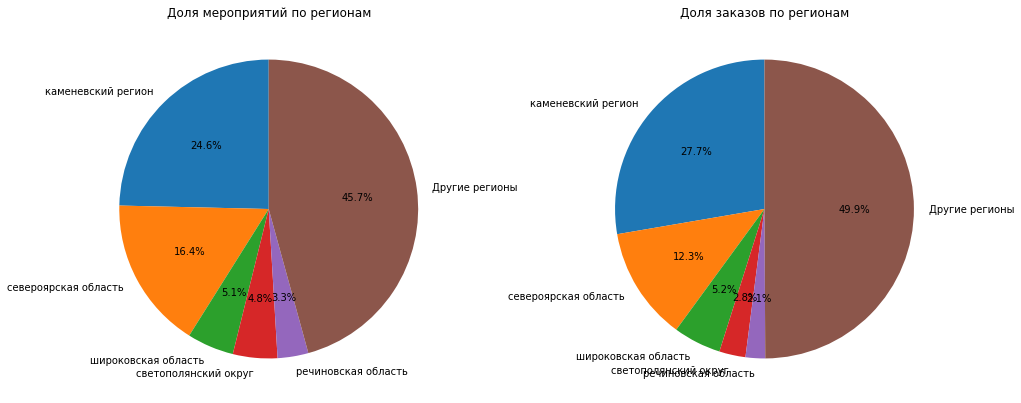

In [68]:
# Визуализируем относительные значения 
# Создаем строку "Другие регионы"
other_events = total_events - top_regions_events['region_events'].sum()
other_orders = total_orders - top_regions_events['region_orders'].sum()

top_with_other = top_regions_events.append({
                'region_name': 'Другие регионы',
                'events_share': (other_events / total_events * 100).round(2),
                'orders_share': (other_orders / total_orders * 100).round(2)}, ignore_index=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Доля мероприятий с другими регионами
ax1.pie(top_with_other['events_share'],
        labels=top_with_other['region_name'],
        autopct='%1.1f%%',
        startangle=90)
ax1.set_title('Доля мероприятий по регионам')

# Доля заказов с другими регионами
ax2.pie(top_with_other['orders_share'],
        labels=top_with_other['region_name'],
        autopct='%1.1f%%',
        startangle=90)
ax2.set_title('Доля заказов по регионам')

plt.tight_layout()
plt.show()

- Каменевский регион — безусловный лидер, генерирующий 28% заказов при 25% событий, что указывает на высокую эффективность и востребованность мероприятий. Североярская область показывает сбалансированные показатели, а вот Светополянский округ и Речиновская область отстают по заказам (3% заказов при 5% событий), что требует анализа цен, инфраструктуры или маркетинга. Широковская область демонстрирует стабильность.


<b>3.3.2 Анализ партнеров</b>

Для каждого билетного партнёра посчитаем общее число уникальных мероприятий, обработанных заказов и суммарную выручку с заказов билетов. Сделаем акцент на наиболее активных партнёрах.

In [69]:
# Группируем по партнёрам
partner_stats = df_autumn.groupby('service_name').agg(
                unique_events=('event_id', 'nunique'),  # Уникальные мероприятия
                total_orders=('order_id', 'count'),     # Общее число заказов
                total_revenue=('revenue_rub', 'sum')).reset_index()    # Суммарная выручка

# Преобразуем выручку: округляем и убираем экспоненциальную запись
partner_stats['total_revenue'] = partner_stats['total_revenue'].round(2)

# Сортируем по выручке (по убыванию)
partner_stats = partner_stats.sort_values('total_revenue', ascending=False)

# Настраиваем отображение чисел
pd.set_option('display.float_format', '{:,.2f}'.format)

partner_stats

,service_name,unique_events,total_orders,total_revenue
3,билеты без проблем,2844,32319,"12,049,772.77"
24,мой билет,1003,19398,"10,833,981.55"
25,облачко,1409,15478,"10,611,051.68"
21,лови билет!,3616,25788,"10,375,964.64"
8,весь в билетах,599,9406,"9,325,570.69"
5,билеты в руки,2471,25731,"7,611,798.90"
19,край билетов,193,2996,"3,016,152.23"
34,яблоко,537,3473,"2,763,332.31"
26,прачечная,728,5798,"2,548,310.46"
30,тебе билет!,859,3749,"2,137,900.34"


In [70]:
# ТОП-5 партнеров по разнообразию событий
top_5_part = partner_stats.sort_values('unique_events', ascending=False).head(5)
display(top_5_part)

,service_name,unique_events,total_orders,total_revenue
21,лови билет!,3616,25788,"10,375,964.64"
3,билеты без проблем,2844,32319,"12,049,772.77"
5,билеты в руки,2471,25731,"7,611,798.90"
25,облачко,1409,15478,"10,611,051.68"
22,лучшие билеты,1397,12438,"1,672,790.03"


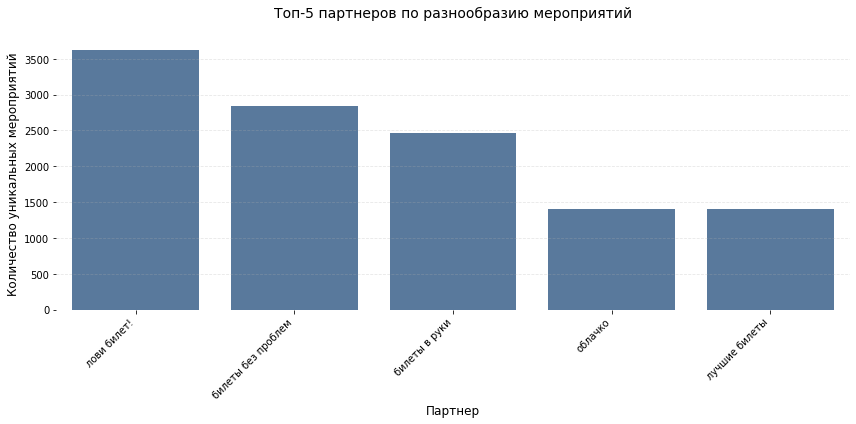

In [71]:
plt.figure(figsize=(12, 6))

# Создаем столбчатую диаграмму
ax = sns.barplot(data=top_5_part,
                x='service_name',
                y='unique_events',
                color='#4e79a7',  
                saturation=0.75)

plt.title('Топ-5 партнеров по разнообразию мероприятий', pad=20, fontsize=14)
plt.xlabel('Партнер', fontsize=12)
plt.ylabel('Количество уникальных мероприятий', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Убираем лишние границы
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()

- "Билеты без проблем" - самый успешный по комплексным показателям (мероприятия, заказы, выручка)
- "Облачко" демонстрирует высокую эффективность - при меньшем количестве мероприятий генерирует большую выручку, чем "Лови билет!" (15.5 тыс событий и 10.61 млн руб. выручка vs 25.8 тыс. событий и 10.38 млн руб. выручка)
- "Лучшие билеты" значительно уступают другим по выручке, несмотря на солидные показатели мероприятий и заказов
- "Лови билет!" лидирует по разнообразию мероприятий, но уступает по монетизации

In [72]:
# Расчитаем доли по каждой метрике
# ТОП-5 партнеров по разнообразию событий
top_5_part = partner_stats.sort_values('unique_events', ascending=False).head(5).copy()

# Рассчитываем общие суммы по всем партнерам
total_events = partner_stats['unique_events'].sum()
total_orders = partner_stats['total_orders'].sum()
total_revenue = partner_stats['total_revenue'].sum()

# Добавляем колонки с долями
top_5_part['Доля событий, %'] = (top_5_part['unique_events'] / total_events * 100).round(1)
top_5_part['Доля заказов, %'] = (top_5_part['total_orders'] / total_orders * 100).round(1)
top_5_part['Доля выручки, %'] = (top_5_part['total_revenue'] / total_revenue * 100).round(1)

# Форматируем вывод
pd.set_option('display.float_format', '{:,.1f}'.format)

# Переименовываем колонки для красоты
top_5_part = top_5_part.rename(columns={
    'unique_events': 'Уникальные события',
    'total_orders': 'Всего заказов',
    'total_revenue': 'Выручка, руб'})

display(top_5_part[['service_name', 'Уникальные события', 'Доля событий, %', 
                    'Всего заказов', 'Доля заказов, %', 
                    'Выручка, руб', 'Доля выручки, %']])

,service_name,Уникальные события,"Доля событий, %",Всего заказов,"Доля заказов, %","Выручка, руб","Доля выручки, %"
21,лови билет!,3616,20.9,25788,15.3,"10,375,964.6",12.7
3,билеты без проблем,2844,16.4,32319,19.2,"12,049,772.8",14.8
5,билеты в руки,2471,14.3,25731,15.3,"7,611,798.9",9.3
25,облачко,1409,8.1,15478,9.2,"10,611,051.7",13.0
22,лучшие билеты,1397,8.1,12438,7.4,"1,672,790.0",2.0


Лидеры по охвату:
- "Лови билет!" лидирует по числу уникальных событий (20.9%), но занимает лишь 3-е место по выручке (12,7%).
- "Билеты без проблем" — второй по событиям (16.4%), но главный по выручке (14,8%) и заказам (19.2%).

Эффективность монетизации:
- "Облачко" при относительно скромном охвате (8.1% событий) генерирует 13% выручки — лучшая конверсия в деньгах.
- "Лучшие билеты" (8.1% событий → 2% выручки) — наименее эффективны.

Разрыв в прибыльности:
- ТОП-2 партнера ("Билеты без проблем" и "Лови билет!") дают 17.5% выручки, их доли в заказах 37.2%.
- Остальные 3 партнера суммарно приносят 24.3% выручки при 30.5% доли заказов.

Таким образом, разрыв прибыльности составляет примерно 33%, что означает, что остальные партнёры получают больше выручки на каждый заказ по сравнению с ТОП-2

---

# 4. Статистический анализ данных
<b>4.1 Формулировка гипотез №1</b>

Проверим гипотезу, которая предполагает большую активность пользователей мобильных устройств.

Гипотеза №1: Среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств. Используйте данные только за осенний период.

Формулировка гипотез:

- Нулевая гипотеза (H₀): Среднее количество заказов на одного пользователя мобильного приложения не выше среднего количества заказов на одного пользователя стационарных устройств. μ_mobile = μ_desktop

- Альтернативная гипотеза (H₁): Среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств. μ_mobile > μ_desktop

In [73]:
# Отберем осенние месяцы
df_autumn_test = final_data[final_data['season'] == 'осень'].copy()

# Группируем по пользователям и считаем заказы:
user_orders = df_autumn_test.groupby(['user_id', 'device_type_canonical'])['order_id'].count().reset_index()
user_orders

,user_id,device_type_canonical,order_id
0,0005ca5e93f2cf4,mobile,1
1,000898990054619,mobile,2
2,000a55a418c128c,mobile,2
3,001e7037d013f0f,mobile,2
4,00245c702bc343e,mobile,2
...,...,...,...
19047,fff32fc9ad0f9f6,desktop,1
19048,fffcd3dde79eb2c,desktop,2
19049,fffcd3dde79eb2c,mobile,14
19050,fffeeb3c120cf0b,desktop,1


In [74]:
# Формируем группы
mobile_orders = user_orders[user_orders['device_type_canonical'] == 'mobile']['order_id']
desktop_orders = user_orders[user_orders['device_type_canonical'] == 'desktop']['order_id']

In [75]:
# Выведем описательную статистику для сравнения групп
display(pd.DataFrame({'mobile': mobile_orders,'desktop': desktop_orders}).describe())

,mobile,desktop
count,"14,185.0","4,867.0"
mean,9.5,7.0
std,68.0,35.9
min,1.0,1.0
25%,1.0,1.0
50%,2.0,2.0
75%,5.0,4.0
max,"4,335.0","1,492.0"


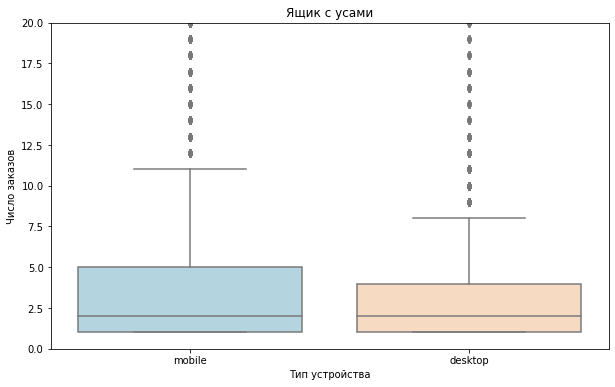

In [76]:
# Строим визализацию распределения (ящики с усами)
plt.figure(figsize=(10, 6))
sns.boxplot(data=user_orders, x='device_type_canonical', y='order_id', 
            palette={'mobile': 'lightblue', 'desktop': 'peachpuff'})

plt.title('Ящик с усами')
plt.ylabel('Число заказов')
plt.xlabel('Тип устройства')
plt.ylim(0, 20)  # Ограничение для детализации
plt.show()

Проблема исходных данных:
- Крайне высокое стандартное отклонение (в 5-7 раз больше среднего)
- Наличие экстремальных выбросов (max=4,366 и 1,510 заказов)
- Сильно различающиеся размеры групп (14,197 и 4,884)
- Для проверки гипотезы применяем U-тест Манна-Уитни из-за наличия экстремальных выбросов.

In [77]:
# Отбираем пользователей с более чем одним заказом, чтобы избежать искажения
# Сначала получим количество заказов для каждого пользователя
user_order_counts = df_autumn_test['user_id'].value_counts()
users_with_multiple_orders = user_order_counts[user_order_counts > 1].index

# Фильтруем исходный DataFrame, оставляя только пользователей с несколькими заказами
df_filters = df_autumn_test[df_autumn_test['user_id'].isin(users_with_multiple_orders)]

# Формируем две группы для сравнения
mobile_users = df_filters[df_filters['device_type_canonical'] == 'mobile']
desktop_users = df_filters[df_filters['device_type_canonical'] == 'desktop']

# Проверим независимость групп
mobile_ids = set(mobile_users['user_id'])
desktop_ids = set(desktop_users['user_id'])

# Пользователи, которые есть в обеих группах (пересечение)
common_users = mobile_ids & desktop_ids
print(f"Количество пользователей в обеих группах: {len(common_users)}")

# Уникальные для mobile
only_mobile = mobile_ids - desktop_ids
print(f"Только mobile: {len(only_mobile)}")

# Уникальные для desktop
only_desktop = desktop_ids - mobile_ids
print(f"Только desktop: {len(only_desktop)}")

# Находим пользователей, которые есть в обеих группах
hybrid_users = set(mobile_users['user_id']) & set(desktop_users['user_id'])

# Удаляем их из анализа
df_filter_cleans = df_filters[~df_filters['user_id'].isin(hybrid_users)]

# Сформируем новые группы 
# mobile_clean_users = df_fall_test[df_fall_test['device_type_canonical'] == 'mobile']
# desktop_clean_users = df_fall_test[df_fall_test['device_type_canonical'] == 'desktop']

Количество пользователей в обеих группах: 3249
,Только mobile: 5564
,Только desktop: 579


In [78]:
# Группируем по пользователям и считаем заказы:
user_orders_c = df_filter_cleans.groupby(['user_id', 'device_type_canonical'])['order_id'].count().reset_index()

# Формируем группы
mobile_orders_c = user_orders_c[user_orders_c['device_type_canonical'] == 'mobile']['order_id']
desktop_orders_c = user_orders_c[user_orders_c['device_type_canonical'] == 'desktop']['order_id']

In [79]:
# Проводим U-тест Манна-Уитни
alpha = 0.05
stat, p_value = mannwhitneyu(mobile_orders, 
                            desktop_orders,
                            alternative='greater')  # Правосторонняя проверка
print(f'p-значение: {p_value:.8f}') 
if p_value < alpha:
    print("Отвергаем нулевую гипотезу: среднее количество заказов мобильных пользователей значимо выше")
else:
    print("Не отвергаем нулевую гипотезу: нет доказательств, что среднее количество заказов мобильных пользователей значимо выше")

p-значение: 0.00000033
,Отвергаем нулевую гипотезу: среднее количество заказов мобильных пользователей значимо выше


- Вывод: Различия между выборками статистически значимы (гипотеза о равенстве распределений отвергается).
- Это свидетельствует о том, что пользователи мобильных устройств ведут себя иначе, чем десктопные (например, дольше задерживаются, чаще совершают целевые действия и т.п.).

<b>4.1 Проверьте гипотезы №2</b>

Гипотеза №2: Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.

Формулировка гипотез:

- Нулевая гипотеза (H₀): Среднее время между заказами пользователей мобильных приложений не выше среднего времени между заказами пользователей стационарных устройств. μ_mobile = μ_desktop

- Альтернативная гипотеза (H₁): Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств. μ_mobile > μ_desktop

In [80]:
# Отберем осенние месяцы
df_fall_test = final_data[final_data['season'] == 'осень'].copy()

# Удаляем строки, где days_since_prev = "нет" (преобразуем их в NaN)
df_fall_test['days_since_prev'] = pd.to_numeric(df_fall_test['days_since_prev'], errors='coerce')

# Удаляем оставшиеся пропуски (первые заказы пользователей)
df_fall_test = df_fall_test.dropna(subset=['days_since_prev'])

# Проверяем результат
print(f"Осталось записей: {len(df_fall_test)}")
print(f"Уникальных пользователей: {df_fall_test['user_id'].nunique()}")

Осталось записей: 160168
,Уникальных пользователей: 11194


In [81]:
# Выводим описательную статистику по устройствам
print("Статистика времени между заказами:")
display(df_fall_test.groupby('device_type_canonical')['days_since_prev'].describe())

Статистика времени между заказами:


,count,mean,std,min,25%,50%,75%,max
device_type_canonical,,,,,,,,
desktop,"32,899.0",3.0,12.1,0.0,0.0,0.0,1.0,146.0
mobile,"127,269.0",3.8,13.4,0.0,0.0,0.0,1.0,148.0


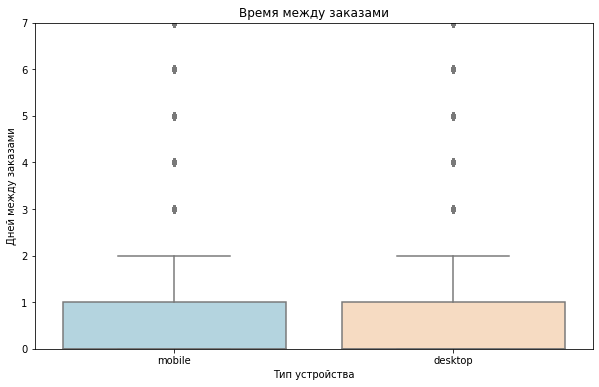

In [82]:
# Строим ящик с усами
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_fall, x='device_type_canonical', y='days_since_prev',
           palette={'mobile': 'lightblue', 'desktop': 'peachpuff'})

plt.title("Время между заказами")
plt.ylabel('Дней между заказами')
plt.xlabel('Тип устройства')
plt.ylim(0, 7)  # Ограничиваем диапазон для наглядности
plt.show()

- Разница в средних (3 vs 3.8 дня) обусловлена более высокой долей активных пользователей среди мобильных и большим количеством повторных заказов.
- Однако стандартные отклонения очень велики (13.4 и 12.1 дней), что указывает на высокую вариативность данных.
- Медианные значения (0 дней): у более 50% пользователей в обеих группах время между заказами равно 0 дней. Это значает, что большинство заказов совершается: либо в тот же день (например, несколько заказов за один день) , либо данные содержат,например, дубли заказов или ошибки.
- Min значение: 0 заказов для обеих групп, Max значение: 146 и 148, т.е. есть "суперпокупатели" с десятками заказов, искажающие среднее.
- Для проверки гипотезы применяем U-тест Манна-Уитни из-за наличия выбросов.

In [83]:
# Отбираем пользователей с более чем одним заказом, чтобы избежать искажения
# Сначала получим количество заказов для каждого пользователя
user_order_counts = df_fall_test['user_id'].value_counts()
users_with_multiple_orders = user_order_counts[user_order_counts > 1].index

# Фильтруем исходный DataFrame, оставляя только пользователей с несколькими заказами
df_filter = df_fall_test[df_fall_test['user_id'].isin(users_with_multiple_orders)]

In [84]:
# Формируем две группы для сравнения
mobile_users = df_filter[df_filter['device_type_canonical'] == 'mobile']
desktop_users = df_filter[df_filter['device_type_canonical'] == 'desktop']

In [85]:
# Проверим независимость групп
mobile_ids = set(mobile_users['user_id'])
desktop_ids = set(desktop_users['user_id'])

# Пользователи, которые есть в обеих группах (пересечение)
common_users = mobile_ids & desktop_ids
print(f"Количество пользователей в обеих группах: {len(common_users)}")

# Уникальные для mobile
only_mobile = mobile_ids - desktop_ids
print(f"Только mobile: {len(only_mobile)}")

# Уникальные для desktop
only_desktop = desktop_ids - mobile_ids
print(f"Только desktop: {len(only_desktop)}")

Количество пользователей в обеих группах: 3027
,Только mobile: 4321
,Только desktop: 418


In [86]:
# Находим пользователей, которые есть в обеих группах
hybrid_users = set(mobile_users['user_id']) & set(desktop_users['user_id'])

# Удаляем их из анализа
df_filter_clean = df_filter[~df_filter['user_id'].isin(hybrid_users)]

In [87]:
# Сформируем новые группы 
mobile_clean_users = df_filter_clean[df_filter_clean['device_type_canonical'] == 'mobile']
desktop_clean_users = df_filter_clean[df_filter_clean['device_type_canonical'] == 'desktop']

In [88]:
# Запускаем тест
alpha = 0.05
u_stat, p_value = stats.mannwhitneyu(mobile_clean_users['days_since_prev'],
                                     desktop_clean_users['days_since_prev'],
                                     alternative='greater')

print(f"p-value: {p_value:.4f}")

if p_value < alpha:
    print("Отвергаем нулевую гипотезу: среднее время между заказами мобильных пользователей значимо выше")
else:
    print("Не отвергаем нулевую гипотезу: нет доказательств, что среднее время между заказами мобильных пользователей выше")

p-value: 0.0000
,Отвергаем нулевую гипотезу: среднее время между заказами мобильных пользователей значимо выше


- Вывод: Различия между выборками статистически значимы (гипотеза о равенстве распределений отвергается).
- Это свидетельствует о том, что среднее время между заказами у мобильных пользователей действительно выше, чем у пользователей стационарных устройств.
---

# 5. Общий вывод и рекомендации

- В Pandas были загружены данные трех датасетов `final_tickets_orders_df.csv`, `final_tickets_events_df.csv`, `final_tickets_tenge_df.csv`, которые после обЪединения содержали 24 столбца и 290849 строк, в которых представлена информация о бронировании билетов на сервисе Яндекс Афиша за период с 1 июня по 30 октября 2024 года, включает данные о заказах билетов, событиях, городах и регионах событий, площадках мероприятий, о курсе тенге к российскому рублю за 2024 год.

- При первичном знакомстве с данными и их предобработке выявили, что в одиннадцати столбцах есть пропущенные значения, которые образовались в результате обЪединения датафреймов. В десяти из которых (содержащих информацию о событиях) пропуски были заменены на заглушки `unknown` и `-1`. В столбце `days_since_prev`, образованы по причине отсутствия покупок у пользователей - оставлены без изменений, чтобы избежать искажения данных. Выполнено понижение размерности в столбцах. В четырех столбцах данные приведены к нижнему регистру. По столбцу `revenue` с выручкой отфильтрованы данные до 99-го перцентиля, исключив выбросы и сохранив репрезентативность. Явных дубликатов нет, неявные - 28 (удалены). Созданы новые столбцы: `revenue_rub` — выручка с заказа к единой валюте (российский рубль), `one_ticket_revenue_rub` — выручка с продажи одного билета на мероприятие, `month` — месяц оформления заказа, `season` — сезон. Удалено 1% данных (выбросы). Итоговый объем - 287752 строк.

- Анализ данных показал, что по популярности мероприятий по обоим сезонам лидируют — концерты, другое и театры. Осенью наблюдается спад концертов, рост спроса на стендап и ёлки, выставки и фестивали стабильны, театр и спорт теряют аудиторию. Осенью заказов в 2+ раза больше, чем летом, пики в начале сентября и октября (учебный сезон, праздники). Осенью средний чек снижается по всем типам мероприятий, кроме выставок и стендапа, котрые демонстрируют незначительный рост. Но в выходные и на премьеры — в целом выше. Активность пользователей осенью возрастает, в среднем 2–3 билета на человека, но в начале октября выше — групповые покупки (6+). Среди регионов и партнёров явные лидеры по числу заказов и выручке с продажи билетов: Каменевский регион, Североярская область, «Билеты без проблем» (максимум заказов), «Облачко» (высокая выручка).

- По результам проверки гипотез мобильные пользователи делают значительно больше заказов, чем десктопные. Мобильное приложение стимулирует частые покупки — возможно, за счёт удобства или push-уведомлений. По времени между заказами у мобильных пользователей дольше перерывы между заказами. Вероятно, мобильные заказы могут быть более спонтанными, а десктопные — запланированными (например, крупные покупки). Мобильные пользователи заказывают реже, но в большем объёме.

Рекомендации:

Продвигать стендап и ёлки осенью. Изучить причины спада театра и спроса в выходные. Для десктопных пользователей — подписки/напоминания о повторных заказах. Для мобильных — скидки на повторные заказы, акции на групповые покупки или премиум-услуги. Осенью аудитория переключается на другие события, растут групповые покупки. Важно работать с партнёрами и регионами-лидерами.